# Predicting convex hulls for compounds

In [ ]:
import pickle
import pickle
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
import pandas as pd
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDEntry, PDPlotter
from pymatgen.core.composition import Composition
from matplotlib import pyplot as plt
from pymatgen.core.periodic_table import Element
import numpy as np
import math

In [10]:
with open("./model/rf_classify.pickle", "rb") as file:
    rf_classify = pickle.load(file)
with open("./model/nn_classify.pickle", "rb") as file:
    nn_classify = pickle.load(file)  
with open("./model/rf_regress.pickle", "rb") as file:
    rf_regress = pickle.load(file)    
with open("./model/nn_regress.pickle", "rb") as file:
    nn_regress = pickle.load(file)
with open("./model/minmax_scaler1.pickle", "rb") as file:
    minmax_scaler_classify = pickle.load(file)
with open("./model/minmax_scaler2.pickle", "rb") as file:
    minmax_scaler_regress= pickle.load(file)    
database = pd.read_csv("./data/targets.csv")[['formula', 'Ef', 'num_atoms']]
  


In [12]:
def featuraztion(data, scaler):
    data = StrToComposition(target_col_id='composition').featurize_dataframe(data, 'formula')
    feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                              cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
    feature_labels = feature_calculators.feature_labels()
    data = feature_calculators.featurize_dataframe(data, col_id='composition')
    data = data[feature_labels].to_numpy()
    data = scaler.transform(data)
    return data

def generate_data(A, B, x, y):
    formula_list = []
    atom_num_list = []
    for i in range(1, x+1):
        for j in range(1, y+1):
            if math.gcd(i, j) == 1:
                formula = f'{A}{i}{B}{j}'.format(A, i, B, j)
                
                formula_list.append(Composition(formula).reduced_formula)
                atom_num_list.append(str(i+j))
    data = pd.DataFrame(np.array([formula_list, atom_num_list]).T, columns=['formula', 'num_atoms'], dtype='string')
    return data

def generate_data1(database, element1, element2):
    formula_list = []
    atom_num_list = []
    metal_elements = ['Ac', 'Th', 'Pa', 'U', 'Np', 'Pu']
    # database = database[database['Ef']<0]
    for formula in database['formula']:
        comp = Composition(formula)
        num_elements = len(comp.elements)
        ele_list = []
        for i in comp.elements:
                ele_list.append(i.symbol)
        if len(ele_list) == 2 :    
            if len(set(ele_list) & set(metal_elements)) != 2:     
                for i in comp.elements:
                    if i.symbol in metal_elements:
                        comp = comp.replace({i.symbol: {element1: 1}})
                        # print(comp, comp.num_atoms)
                    else:
                        comp = comp.replace({i.symbol: {element2: 1}})
                        # print(comp, comp.num_atoms)
                atom_num_list.append(comp.num_atoms)
                formula_list.append(comp.reduced_formula)
    data = pd.DataFrame(np.array([formula_list, atom_num_list]).T, columns=['formula', 'num_atoms'], dtype='string')
    data = data.drop_duplicates()
    return data


def prediction_phase(data, classify, regress):
    X_classify = featuraztion(data, minmax_scaler_classify)
    classify_list = classify.predict(X_classify)
    # print(classify_list)
    X_classify = featuraztion(data, minmax_scaler_regress)
    X_regress = X_classify[classify_list==1]
    # X_regress = x_sca.transform(X_regress)
    regress_list = regress.predict(X_regress)
    # print(regress_list)
    energy_list = regress_list.tolist()
    composition_list = data[classify_list==1]['formula'].to_numpy()
    num_atoms_list = data[classify_list==1]['num_atoms'].to_numpy()
    data = np.array([composition_list, energy_list]).T
    data = pd.DataFrame(np.array([composition_list, energy_list, num_atoms_list]).T, columns=['formula', 'Ef', 'num_atoms'])
    data['num_atoms'].astype('float')
    return data

def prediction_phase1(data, classify, regress):
    X_classify = featuraztion(data, minmax_scaler_classify)
    classify_list0 = classify[0].predict(X_classify)
    classify_list1 = classify[1].predict(X_classify)
    classify_list = (classify_list0 & classify_list1)
    print(classify_list)
    X_classify = featuraztion(data, minmax_scaler_regress)
    X_regress = X_classify[classify_list==1]
    # X_regress = x_sca.transform(X_regress)
    regress_list0 = regress[0].predict(X_regress)
    regress_list1 = regress[1].predict(X_regress)
    regress_list = (regress_list0 + regress_list1) / 2
    # print(regress_list)
    energy_list = regress_list.tolist()
    composition_list = data[classify_list==1]['formula'].to_numpy()
    num_atoms_list = data[classify_list==1]['num_atoms'].to_numpy()
    data = np.array([composition_list, energy_list]).T
    data = pd.DataFrame(np.array([composition_list, energy_list, num_atoms_list]).T, columns=['formula', 'Ef', 'num_atoms'])
    data['num_atoms'].astype('float')
    return data

def plot_phase(composition_list, energy_list, element1, element2):
    composition_list += [element1, element2]
    energy_list += [0, 0]
    pde_list = []
    for compsition, energy in zip(composition_list, energy_list):
        comp = Composition(compsition)
        pde = PDEntry(comp, energy)
        pde_list.append(pde)
    phase_diagram = PhaseDiagram(pde_list)
    pd_plotter = PDPlotter(phase_diagram, backend="matplotlib")
    pd_plotter.get_plot(label_unstable=False, label_stable=True)
    print(phase_diagram.stable_entries) 
    print(phase_diagram.unstable_entries)
    


# Single model

RandomForestClassifier(n_estimators=40, n_jobs=-1, random_state=42) RandomForestRegressor(n_estimators=40, n_jobs=-1, random_state=42)


/home/gengzi/miniconda3/envs/actinide/lib/python3.9/site-packages/pymatgen/core/composition.py:773: UserWarning: Same element (U) in both the keys and values of the substitution!This can be ambiguous, so be sure to check your result.
  warnings.warn(
/home/gengzi/miniconda3/envs/actinide/lib/python3.9/site-packages/pymatgen/core/composition.py:773: UserWarning: Same element (N) in both the keys and values of the substitution!This can be ambiguous, so be sure to check your result.
  warnings.warn(
MultipleFeaturizer: 100%|██████████| 25/25 [00:00<00:00, 64.58it/s]
/home/gengzi/miniconda3/envs/actinide/lib/python3.9/site-packages/pymatgen/core/composition.py:773: UserWarning: Same element (U) in both the keys and values of the substitution!This can be ambiguous, so be sure to check your result.
  warnings.warn(
/home/gengzi/miniconda3/envs/actinide/lib/python3.9/site-packages/pymatgen/core/composition.py:773: UserWarning: Same element (N) in both the keys and values of the substitution!T

{PDEntry : U1 N13 with energy = -8.1283, PDEntry : U2 N3 with energy = -7.5635, PDEntry : U1 with energy = 0.0000, PDEntry : U1 N1 with energy = -2.8317, PDEntry : N1 with energy = 0.0000, PDEntry : U1 N2 with energy = -4.4856}
{PDEntry : U1 N12 with energy = -7.5477, PDEntry : U1 N6 with energy = -3.7252, PDEntry : U2 N9 with energy = -3.6457, PDEntry : U7 N12 with energy = -25.6954, PDEntry : U3 N5 with energy = -10.9776, PDEntry : U3 N2 with energy = -4.1875, PDEntry : U3 N1 with energy = 0.9873, PDEntry : U2 N7 with energy = -2.5170, PDEntry : U7 N3 with energy = -4.1414, PDEntry : U4 N3 with energy = -5.2480, PDEntry : U5 N4 with energy = -7.6680, PDEntry : U6 N23 with energy = -8.7366, PDEntry : U3 N4 with energy = -10.0438, PDEntry : U4 N15 with energy = -5.3136, PDEntry : U2 N5 with energy = -3.7295, PDEntry : U5 N3 with energy = -4.6860, PDEntry : U4 N5 with energy = -12.8496, PDEntry : U1 N5 with energy = -1.9948, PDEntry : U1 N4 with energy = -1.5905, PDEntry : U11 N16 with 

MultipleFeaturizer: 100%|██████████| 25/25 [00:00<00:00, 64.41it/s]


{PDEntry : U2 N3 with energy = -7.5635, PDEntry : U1 with energy = 0.0000, PDEntry : U11 N16 with energy = -40.8273, PDEntry : U1 N1 with energy = -2.8317, PDEntry : N1 with energy = 0.0000, PDEntry : U1 N2 with energy = -4.4856, PDEntry : U4 N5 with energy = -13.4828, PDEntry : U6 N7 with energy = -19.2141}
{PDEntry : U3 N5 with energy = -11.6590, PDEntry : U1 N5 with energy = -0.3838, PDEntry : U3 N2 with energy = -4.1875, PDEntry : U1 N7 with energy = -0.6225, PDEntry : U3 N1 with energy = 0.9873, PDEntry : U2 N5 with energy = -3.8750, PDEntry : U3 N4 with energy = -10.0438, PDEntry : U2 N7 with energy = -0.5873, PDEntry : U5 N4 with energy = -9.5769, PDEntry : U2 N1 with energy = -1.5990, PDEntry : U6 N1 with energy = -1.2930, PDEntry : U7 N12 with energy = -27.1746, PDEntry : U1 N4 with energy = -0.2757, PDEntry : U7 N3 with energy = -4.3004, PDEntry : U2 N9 with energy = -0.6300, PDEntry : U3 N8 with energy = -4.2117, PDEntry : U1 N13 with energy = -1.5359, PDEntry : U4 N15 with 

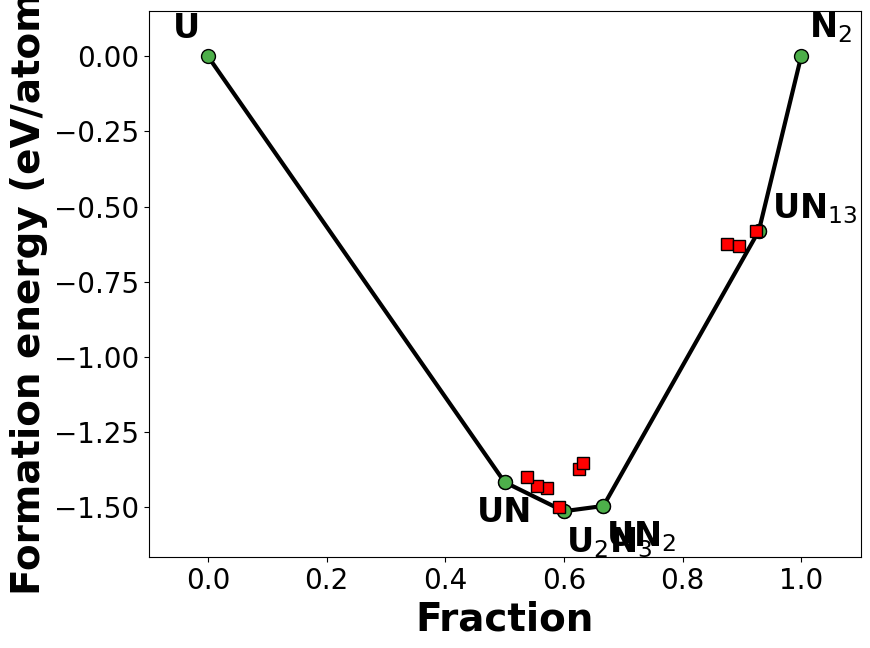

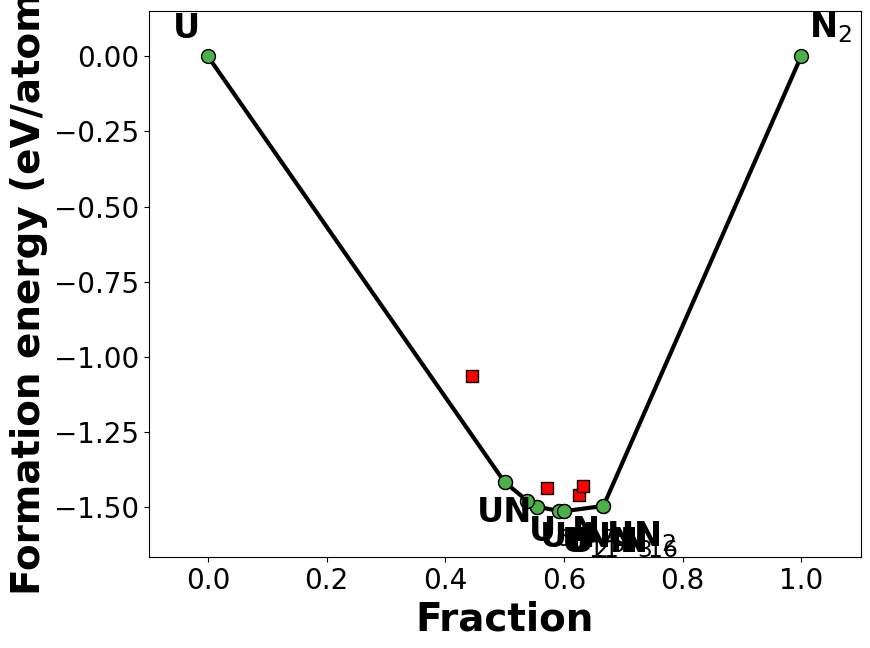

In [19]:
element1 = 'U'
element2 = 'N'
for classify, regress in zip([rf_classify, nn_classify], [rf_regress, nn_regress]):
    print(classify, regress)
    data = generate_data1(database, element1, element2)
    # data = generate_data( element1, element2, 30, 30)
    data = data.iloc[:-1, :]
    # data = generate_data('U', 'Si', 50, 50) 
    data_exist = database[database['formula'].isin(data['formula'])].loc[:, ['formula', 'Ef', 'num_atoms']]
    data_not_exist = data[~data['formula'].isin(database['formula'])]
    # print(data_not_exist)
    data_prediction = prediction_phase(data_not_exist, classify, regress)
    data1 = pd.concat((data_exist, data_prediction))
    composition_list = data1['formula'].tolist()
    energy_list = list(data1['Ef'].to_numpy() * data1['num_atoms'].to_numpy().astype('float'))
    plot_phase(composition_list, energy_list, element1, element2)

# Ensemble learning approach (RF + NN)

/home/gengzi/miniconda3/envs/actinide/lib/python3.9/site-packages/pymatgen/core/composition.py:773: UserWarning: Same element (U) in both the keys and values of the substitution!This can be ambiguous, so be sure to check your result.
  warnings.warn(
/home/gengzi/miniconda3/envs/actinide/lib/python3.9/site-packages/pymatgen/core/composition.py:773: UserWarning: Same element (N) in both the keys and values of the substitution!This can be ambiguous, so be sure to check your result.
  warnings.warn(
MultipleFeaturizer: 100%|██████████| 25/25 [00:00<00:00, 60.35it/s]


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]


MultipleFeaturizer: 100%|██████████| 25/25 [00:00<00:00, 61.68it/s]


{PDEntry : U1 N13 with energy = -4.8321, PDEntry : U2 N3 with energy = -7.5635, PDEntry : U1 with energy = 0.0000, PDEntry : U1 N1 with energy = -2.8317, PDEntry : N1 with energy = 0.0000, PDEntry : U1 N2 with energy = -4.4856}
{PDEntry : U1 N12 with energy = -4.4794, PDEntry : U1 N7 with energy = -2.8025, PDEntry : U3 N2 with energy = -4.1875, PDEntry : U3 N8 with energy = -4.8150, PDEntry : U3 N1 with energy = 0.9873, PDEntry : U4 N3 with energy = -6.0672, PDEntry : U2 N7 with energy = -1.5521, PDEntry : U1 N4 with energy = -0.9331, PDEntry : U3 N4 with energy = -10.0438, PDEntry : U7 N3 with energy = -4.2209, PDEntry : U3 N5 with energy = -11.3183, PDEntry : U5 N3 with energy = -5.2153, PDEntry : U6 N7 with energy = -18.7027, PDEntry : U4 N5 with energy = -13.1662, PDEntry : U2 N17 with energy = -6.7995, PDEntry : U11 N16 with energy = -40.6489, PDEntry : U5 N4 with energy = -8.6225, PDEntry : U4 N15 with energy = -3.1563, PDEntry : U6 N23 with energy = -5.1401, PDEntry : U2 N5 with

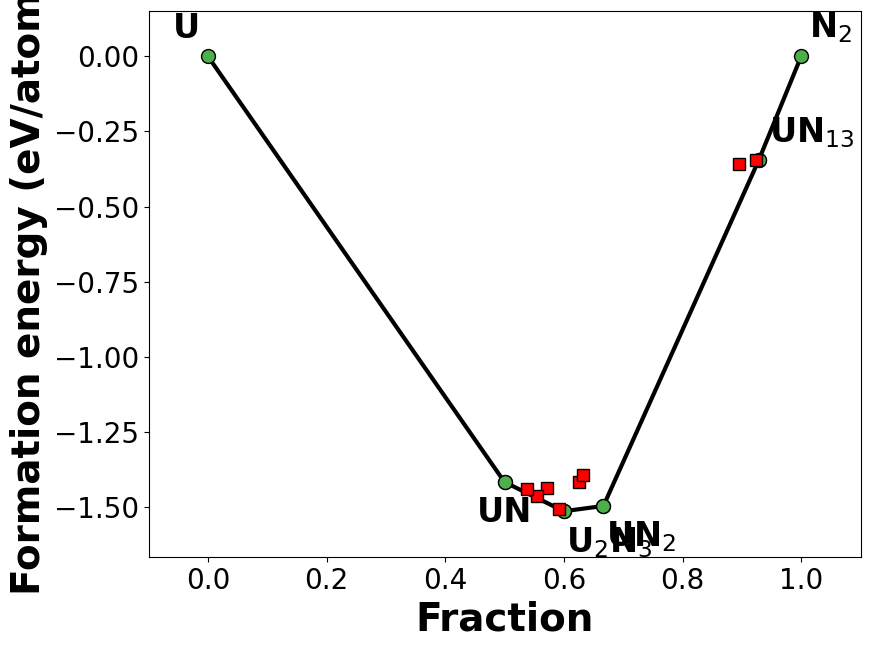

In [16]:
element1 = 'U'
element2 = 'N'

classify = [rf_classify, nn_classify]
regress = [rf_regress, nn_regress]
data = generate_data1(database, element1, element2)
# data = generate_data( element1, element2, 30, 30)
data = data.iloc[:-1, :]
# data = generate_data('U', 'Si', 50, 50) 
data_exist = database[database['formula'].isin(data['formula'])].loc[:, ['formula', 'Ef', 'num_atoms']]
data_not_exist = data[~data['formula'].isin(database['formula'])]
# print(data_not_exist)
data_prediction = prediction_phase1(data_not_exist, classify, regress)
data1 = pd.concat((data_exist, data_prediction))
composition_list = data1['formula'].tolist()
energy_list = list(data1['Ef'].to_numpy() * data1['num_atoms'].to_numpy().astype('float'))
plot_phase(composition_list, energy_list, element1, element2)